In [ ]:
# default_exp hw3

# Import

In [ ]:
# export
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

from cs371.utils import *

# Alignment tools

In [ ]:
def dist_euclidean(X, Y, i, j):
    """
    Parameters
    ---------
    X: ndarray(M, d)
        A d-dimensional Euclidean point cloud with M points
    Y: ndarray(N, d)
        A d-dimensional Euclidean point cloud with N points
    i: int
        Index of point in first point cloud
    j: int
        Index of point in second point cloud
    
    Returns
    -------
    float: The distance between the two points
    """
    return np.sqrt(np.sum((X[i, :] - Y[j, :])**2))

In [ ]:
def get_csm(X, Y):
    """
    Return the Euclidean cross-similarity matrix between X and Y

    Parameters
    ---------
    X: ndarray(M, d)
        A d-dimensional Euclidean point cloud with M points
    Y: ndarray(N, d)
        A d-dimensional Euclidean point cloud with N points
    
    Returns
    -------
    D: ndarray(M, N)
        The cross-similarity matrix
    
    """
    XSqr = np.sum(X**2, 1)
    YSqr = np.sum(Y**2, 1)
    C = XSqr[:, None] + YSqr[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)

In [ ]:
def get_ssm(X):
    """
    Return the SSM between all rows of a time-ordered Euclidean point cloud X

    Parameters
    ---------
    X: ndarray(M, d)
        A d-dimensional Euclidean point cloud with M points
    
    Returns
    -------
    D: ndarray(M, M)
        The self-similarity matrix
    """
    return get_csm(X, X)

In [ ]:
def get_path_cost(X, Y, path):
    """
    Return the cost of a warping path that matches two Euclidean 
    point clouds

    Parameters
    ---------
    X: ndarray(M, d)
        A d-dimensional Euclidean point cloud with M points
    Y: ndarray(N, d)
        A d-dimensional Euclidean point cloud with N points
    P1: ndarray(K, 2)
        Warping path
    
    Returns
    -------
    cost: float
        The sum of the Euclidean distances along the warping path 
        between X and Y
    """
    x = X[path[:, 0], :]
    y = Y[path[:, 1], :]
    ds = np.sqrt(np.sum((x-y)**2, 1))
    return np.sum(ds)

In [ ]:
def make_path_strictly_increase(path):
    """
    Given a warping path, remove all rows that do not
    strictly increase from the row before
    """
    toKeep = np.ones(path.shape[0])
    i0 = 0
    for i in range(1, path.shape[0]):
        if np.abs(path[i0, 0] - path[i, 0]) >= 1 and np.abs(path[i0, 1] - path[i, 1]) >= 1:
            i0 = i
        else:
            toKeep[i] = 0
    return path[toKeep == 1, :]

In [ ]:
def refine_warping_path(path):
    """
    An implementation of the technique in section 4 of 
    "Refinement Strategies for Music Synchronization" by Ewert and Müller

    Parameters
    ----------
    path: ndarray(K, 2)
        A warping path
    
    Returns
    -------
    path_refined: ndarray(N >= K, 2)
        A refined set of correspondences
    """
    N = path.shape[0]
    ## Step 1: Identify all vertical and horizontal segments
    vert_horiz = []
    i = 0
    while i < N-1:
        if path[i+1, 0] == path[i, 0]:
            # Vertical line
            j = i+1
            while path[j, 0] == path[i, 0] and j < N-1:
                j += 1
            if j < N-1:
                vert_horiz.append({'type':'vert', 'i':i, 'j':j-1})
                i = j-1
            else:
                vert_horiz.append({'type':'vert', 'i':i, 'j':j})
                i = j
        elif path[i+1, 1] == path[i, 1]:
            # Horizontal line
            j = i+1
            while path[j, 1] == path[i, 1] and j < N-1:
                j += 1
            if j < N-1:
                vert_horiz.append({'type':'horiz', 'i':i, 'j':j-1})
                i = j-1
            else:
                vert_horiz.append({'type':'horiz', 'i':i, 'j':j})
                i = j
        else:
            i += 1
    
    ## Step 2: Compute local densities
    xidx = []
    density = []
    i = 0
    vhi = 0
    while i < N:
        inext = i+1
        if vhi < len(vert_horiz) and vert_horiz[vhi]['i'] == i: # This is a vertical or horizontal segment
            v = vert_horiz[vhi]
            n_seg = v['j']-v['i']+1
            xidxi = []
            densityi = []
            n_seg_prev = 0
            n_seg_next = 0
            if vhi > 0:
                v2 = vert_horiz[vhi-1]
                if i == v2['j']:
                    # First segment is at a corner
                    n_seg_prev = v2['j']-v2['i']+1
            if vhi < len(vert_horiz) - 1:
                v2 = vert_horiz[vhi+1]
                if v['j'] == v2['i']:
                    # Last segment is a corner
                    n_seg_next = v2['j']-v2['i']+1
            # Case 1: Vertical Segment
            if v['type'] == 'vert':
                xidxi = [path[i, 0] + k/n_seg for k in range(n_seg+1)]
                densityi = [n_seg]*(n_seg+1)
                if n_seg_prev > 0:
                    densityi[0] = n_seg/n_seg_prev
                if n_seg_next > 0:
                    densityi[-2] = n_seg/n_seg_next
                    densityi[-1] = n_seg/n_seg_next
                    inext = v['j']
                else:
                    inext = v['j']+1
            # Case 2: Horizontal Segment
            else:  
                xidxi = [path[i, 0] + k for k in range(n_seg)]
                densityi = [1/n_seg]*n_seg
                if n_seg_prev > 0:
                    xidxi = xidxi[1::]
                    densityi = densityi[1::]
                if n_seg_next > 0:
                    inext = v['j']
                else:
                    inext = v['j']+1
            xidx += xidxi
            density += densityi
            vhi += 1
        else:
            # This is a diagonal segment
            xidx += [path[i, 0], path[i, 0]+1]
            density += [1, 1]
        i = inext
    
    ## Step 3: Integrate densities
    xidx = np.array(xidx)
    density = np.array(density)
    path_refined = [[0, 0]]
    j = 0
    for i in range(1, xidx.size):
        if xidx[i] > xidx[i-1]:
            j += (xidx[i]-xidx[i-1])*density[i-1]
            path_refined.append([xidx[i], j])
    path_refined = np.array(path_refined)
    return path_refined

In [ ]:
def downsample_trajectory(X, fac=2):
    """
    Downsample a time-ordered Euclidean trajectory 
    safely with anti-aliasing

    Parameters
    ----------
    X: ndarray(N, d)
        A time-ordered point cloud in d-dimensional Euclidean space
    fac: int
        Factor by which to downsample

    Returns
    ndarray(floor(N/fac), d)
        The downsampled time series
    """
    from skimage.transform import resize
    return resize(X, (int(X.shape[0]/fac), X.shape[1]), anti_aliasing=True)

# Audio tools

In [ ]:
def save_audio(wavfilename, x, sr):
    """
    Save audio to a file

    Parameters
    ----------
    wavfilename: string
        Filename to which to save file
    x: ndarray(N, 2)
        Stereo audio to save
    sr: int
        Sample rate of audio to save
    """
    from scipy.io import wavfile
    wavfile.write(wavfilename, sr, x)

In [ ]:
def get_mfcc_mod(x, sr, hop_length, n_mfcc=120, drop=20, n_fft = 2048):
    """
    Compute the mfcc_mod features, as described in Gadermaier 2019

    Parameters
    ----------
    x: ndarray(N)
        Audio samples
    sr: int
        Sample rate
    hop_length: int
        Hop size between windows
    n_mfcc: int
        Number of mfcc coefficients to compute
    drop: int
        Index under which to ignore coefficients
    n_fft: int
        Number of fft points to use in each window
    
    Returns
    -------
    X: ndarray(n_win, n_mfcc-drop)
        The mfcc-mod features
    """
    X = librosa.feature.mfcc(y=x, sr=sr, hop_length=hop_length, n_mfcc = n_mfcc, n_fft=n_fft, htk=True)
    X = X[drop::, :].T
    return X

In [ ]:
def timemap_stretch(x, sr, path, hop_length=32, n_fft = 4096):
    """
    Stretch audio x so that it aligns with another
    audio clip, according to a warping path

    Parameters
    ----------
    x: ndarray(N)
        An array of audio samples
    sr: int
        Sample rate
    path: ndarray(K, 2)
        Warping path.  Indices of x are in first row
    hop_length: int
        Hop length to use in the phase vocoder
    n_fft: int
        Number of fft samples to use in the phase vocoder
    """
    # Break down into regions of constant slope
    xdiff = path[1::, 0] - path[0:-1, 0]
    ydiff = path[1::, 1] - path[0:-1, 1]
    xdiff = xdiff[1::] - xdiff[0:-1]
    ydiff = ydiff[1::] - ydiff[0:-1]
    diff = xdiff + ydiff
    ret = np.array([])
    i1 = 0
    while i1 < len(diff):
        i2 = i1+1
        while i2 < len(diff) and diff[i2] == 0:
            i2 += 1
        while i2 < len(diff) and path[i2, 0] - path[i1, 0] < n_fft:
            i2 += 1
        if i2 >= len(diff):
            break
        fac = (path[i2, 1]-path[i1, 1])/(path[i2, 0]-path[i1, 0])
        if fac > 0:
            fac = 1/fac
            xi = x[path[i1, 0]:path[i2, 0]+1]
            D = librosa.stft(xi, n_fft = n_fft, hop_length=hop_length)
            DNew = librosa.phase_vocoder(D, fac, hop_length=hop_length)
            xifast = librosa.istft(DNew, hop_length=hop_length)
            ret = np.concatenate((ret, xifast))
        i1 = i2
    return ret

In [ ]:
def stretch_audio(x1, x2, sr, path, hop_length):
    """
    Wrap around pyrubberband to warp one audio stream
    to another, according to some warping path

    Parameters
    ----------
    x1: ndarray(M)
        First audio stream
    x2: ndarray(N)
        Second audio stream
    sr: int
        Sample rate
    path: ndarray(P, 2)
        Warping path, in units of windows
    hop_length: int
        The hop length between windows
    
    Returns
    -------
    x3: ndarray(N, 2)
        The synchronized audio.  x2 is in the right channel,
        and x1 stretched to x2 is in the left channel
    """
    print("Stretching...")
    path_final = [(row[0], row[1]) for row in path if row[0] < x1.size and row[1] < x2.size]
    path_final.append((x1.size, x2.size))
    path_final = hop_length*np.array(path_final, dtype=int)
    x3 = np.zeros((x2.size, 2))
    x3[:, 1] = x2
    x1_stretch = timemap_stretch(x1, sr, path_final)
    print("x1.shape = ", x1.shape)
    print("x2.shape = ", x2.shape)
    print("x1_stretch.shape = ", x1_stretch.shape)
    x1_stretch = x1_stretch[0:min(x1_stretch.size, x3.shape[0])]
    x3 = x3[0:min(x3.shape[0], x1_stretch.size), :]
    x3[:, 0] = x1_stretch
    return x3

# Dynamic Time Warping

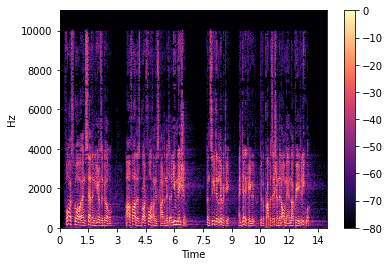

In [ ]:
y, sr = librosa.load('data/gettysburg1.wav')
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db, x_axis='time', y_axis='linear')
plt.colorbar()
plt.show()

Draw all possible warping paths

Create a `choices` array that use every path

In [ ]:
M, N = 4, 4

In [ ]:
choices = np.empty((M, N), dtype=object)

In [ ]:
for i in range(M):
    for j in range(N):
        if   i == 0 and j == 0: pass
        elif i == 0:            choices[i, j]  = [0]
        elif j == 0:            choices[i, j]  = [2]
        else:                   choices[i, j]  = [0,1,2]

In [ ]:
choices

array([[None, list([0]), list([0]), list([0])],
       [list([2]), list([0, 1, 2]), list([0, 1, 2]), list([0, 1, 2])],
       [list([2]), list([0, 1, 2]), list([0, 1, 2]), list([0, 1, 2])],
       [list([2]), list([0, 1, 2]), list([0, 1, 2]), list([0, 1, 2])]],
      dtype=object)

In [ ]:
class GetPaths():
    def __init__(self):
        self.path  = []
        self.paths = []
    
    def _get_paths(self, choices, i, j):
        if i == 0 and j == 0:
            self.path.append((i,j))
            self.paths.append(np.array(self.path.copy()[::-1]))
            self.path.pop()
            return
            
        for choice in choices[i,j]:
            self.path.append((i,j))
            if   choice == 0: self._get_paths(choices, i,   j-1)
            elif choice == 1: self._get_paths(choices, i-1, j-1)
            else:             self._get_paths(choices, i-1,   j)
            self.path.pop()
    
    def __call__(self, choices):
        self._get_paths(choices, choices.shape[0]-1, choices.shape[1]-1)
        return self.paths       

In [ ]:
def get_paths(choices): return GetPaths()(choices)

In [ ]:
def get_path(choices):  return get_paths(choices)[0]

In [ ]:
paths = get_paths(choices)

In [ ]:
len(paths)

63

In [ ]:
def plot_paths(paths, M, N, figsize=(15, 15)):
    l = int(np.ceil(np.sqrt(len(paths))))
    fig, axs = plt.subplots(l, l, figsize=figsize)
    axs = axs.ravel() if isinstance(axs, np.ndarray) else [axs]
    for ax in axs:
        ax.set_aspect(1)
        ax.set_xlim(-0.5, N-0.5)
        ax.set_ylim(-0.5, M-0.5)
        ax.invert_yaxis()
        ax.tick_params(left=False,
                       bottom=False,
                       labelleft=False,
                       labelbottom=False)
        
    for idx, path in enumerate(paths):
        axs[idx].plot(paths[idx][:,1], paths[idx][:,0], '-bs')

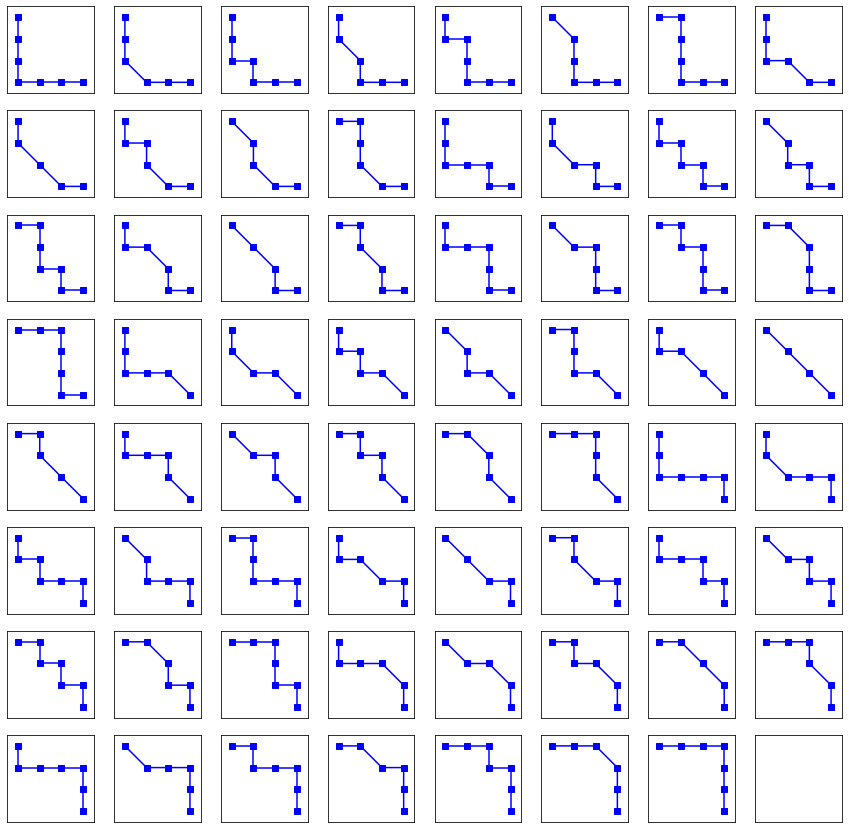

In [ ]:
plot_paths(paths, M, N)

Now do dynamic time warping

In [ ]:
X1 = np.array([[0, 2], [17, 0], [25, 0], [31, 0]])
X2 = np.array([[0, 4], [5, 4], [16, 4], [24, 4], [30, 4]])

In [ ]:
f_cost_euclidean = lambda x1, x2: np.sqrt((x1[0]-x2[0])**2 + (x1[1] - x2[1])**2)

In [ ]:
def _dtw(X1, X2, f_cost=f_cost_euclidean):
    M, N = len(X1), len(X2)
    choices = np.empty((M, N), dtype=object)
    arr_dp  = np.full((M, N), np.inf)
    for i in range(M):
        for j in range(N):
            if   i == 0 and j == 0: 
                arr_dp[i, j] = 0
            elif i == 0:
                arr_dp[i, j] = f_cost(X1[i], X2[j]) + arr_dp[i, j-1]
                choices[i,j] = [0]
            elif j == 0:
                arr_dp[i, j] = f_cost(X1[i], X2[j]) + arr_dp[i-1, j]
                choices[i,j] = [2]
            else:
                min_cost = min(arr_dp[i, j-1], arr_dp[i-1, j-1], arr_dp[i-1, j])
                arr_dp[i, j] = f_cost(X1[i], X2[j]) + min_cost
                choices[i, j] = []
                for idx, cost in enumerate([arr_dp[i, j-1], arr_dp[i-1, j-1], arr_dp[i-1, j]]):
                    if cost == min_cost: choices[i, j].append(idx)
    return choices, arr_dp

In [ ]:
def dtw(X1, X2, f_cost=f_cost_euclidean):
    choices, arr_dp = _dtw(X1, X2, f_cost)
    return get_path(choices)

In [ ]:
path = dtw(X1, X2)

In [ ]:
path

array([[0, 0],
       [0, 1],
       [1, 2],
       [2, 3],
       [3, 4]])

Use more intricate example

In [ ]:
N = 50
t = np.linspace(0, 1, N)
X1 = np.zeros((N, 2))
X1[:, 0] = np.cos(2*np.pi*t)
X1[:, 1] = np.sin(4*np.pi*t)
X2 = np.zeros((N, 2))
X2[:, 0] = 1.3*np.cos(2*np.pi*(t**2))
X2[:, 1] = 1.3*np.sin(4*np.pi*(t**2))+0.1

In [ ]:
choices, arr_dp = _dtw(X1, X2)
paths = get_paths(choices)

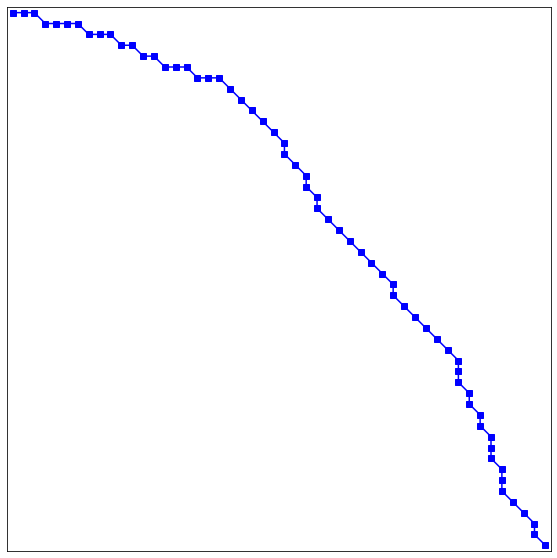

In [ ]:
plot_paths(paths, len(X1), len(X2), figsize=(10, 10))

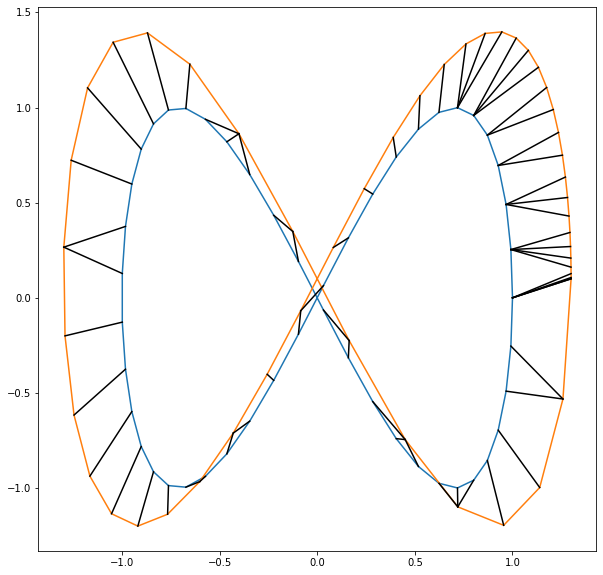

In [ ]:
path = paths[0]

plt.figure(figsize=(10, 10))
plt.plot(X1[:,0], X1[:,1])
plt.plot(X2[:,0], X2[:,1])
for c in path:
    plt.plot([X1[c[0]][0], X2[c[1]][0]], [X1[c[0]][1], X2[c[1]][1]], '-k')

Try audio example

In [ ]:
sr = 22050
hop_length = 512
x1, sr = librosa.load('data/gettysburg1.wav', sr=sr)
x2, sr = librosa.load('data/gettysburg2.wav', sr=sr)
X1 = get_mfcc_mod(x1, sr, hop_length, 20, 0)
X2 = get_mfcc_mod(x2, sr, hop_length, 20, 0)

In [ ]:
path = dtw(X1, X2)
xres = stretch_audio(x1, x2, sr, path, hop_length)
save_audio('data/gettysburg1_2.wav', xres, sr)

Stretching...
x1.shape =  (308700,)
x2.shape =  (441600,)
x1_stretch.shape =  (443424,)


In [ ]:
path = dtw(X2, X1)
xres = stretch_audio(x2, x1, sr, path, hop_length)
save_audio('data/gettysburg2_1.wav', xres, sr)

Stretching...
x1.shape =  (441600,)
x2.shape =  (308700,)
x1_stretch.shape =  (301920,)


Try `fastdtw`

In [ ]:
X1_init = X1
X2_init = X2
num_octaves = 5

In [ ]:
def _upscale_path(path, l):
    return np.c_[np.arange(l), 2*np.interp(np.arange(l)/2, path[:,0], path[:,1])]

In [ ]:
def _dtw_fast(X1, X2, path_init, r, f_cost=f_cost_euclidean):
    M, N = len(X1), len(X2)
    choices = np.empty((M, N), dtype=object)
    arr_dp  = np.full((M, N), np.inf)
    idx_path = 0
    for i in range(M):
        j_min = max(0,   int(path_init[i, 1] - r))
        j_max = min(N-1, int(path_init[i, 1] + r))
        for j in range(j_min, j_max+1):
            if   i == 0 and j == 0: 
                arr_dp[i, j] = 0
            elif i == 0:
                arr_dp[i, j] = f_cost(X1[i], X2[j]) + arr_dp[i, j-1]
                choices[i,j] = [0]
            elif j == 0:
                arr_dp[i, j] = f_cost(X1[i], X2[j]) + arr_dp[i-1, j]
                choices[i,j] = [2]
            else:
                min_cost = min(arr_dp[i, j-1], arr_dp[i-1, j-1], arr_dp[i-1, j])
                arr_dp[i, j] = f_cost(X1[i], X2[j]) + min_cost
                choices[i, j] = []
                for idx, cost in enumerate([arr_dp[i, j-1], arr_dp[i-1, j-1], arr_dp[i-1, j]]):
                    if cost == min_cost: choices[i, j].append(idx)
    return choices, arr_dp

In [ ]:
def fastdtw(X1, X2, num_octaves, r, f_cost=f_cost_euclidean):
    X1_init, X2_init = X1, X2
    arrs_dp, paths = [], []
    
    # Start by doing full DTW on most scaled down X1, X2
    X1 = downsample_trajectory(X1_init, 2**num_octaves)
    X2 = downsample_trajectory(X2_init, 2**num_octaves)
    choices, arr_dp = _dtw(X1, X2, f_cost_euclidean)
    path = get_path(choices)
    arrs_dp.append(arr_dp); paths.append(path)
    
    # Do octaves
    for i in range(1, num_octaves):
        X1 = downsample_trajectory(X1_init, 2**(num_octaves-i))
        X2 = downsample_trajectory(X2_init, 2**(num_octaves-i))
        choices, arr_dp = _dtw_fast(X1, X2, _upscale_path(path, len(X1)), r)
        path = get_path(choices)
        arrs_dp.append(arr_dp); paths.append(path)
    
    # Do final upsample
    choices, arr_dp = _dtw_fast(X1_init, X2_init, _upscale_path(path, len(X1_init)), r)
    path = get_path(choices)
    arrs_dp.append(arr_dp); paths.append(path)
    
    # Now upsample and 
    return paths[-1], (arrs_dp, paths)

In [ ]:
path_fast, (arrs_dp, paths) = fastdtw(X1, X2, 4, 100)

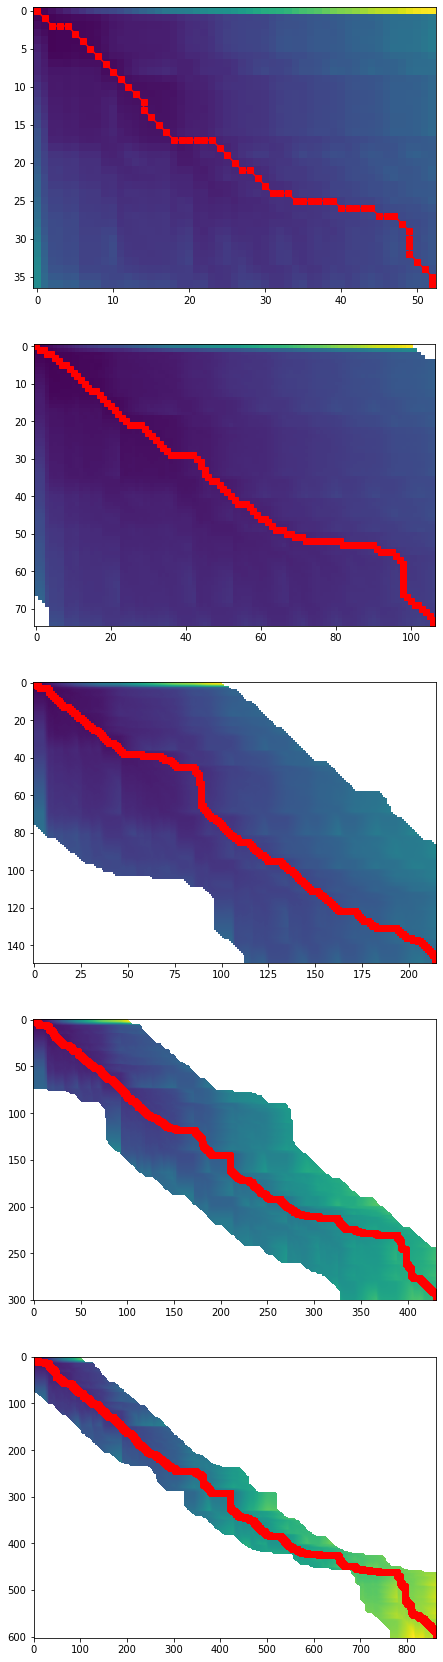

In [ ]:
fig, axs = plt.subplots(len(arrs_dp), 1, figsize=(15, 30))
axs = axs if isinstance(axs, np.ndarray) else [axs]
for arr_dp, path, ax in zip(arrs_dp, paths, axs):
    ax.imshow(arr_dp)
    ax.plot(path[:, 1], path[:, 0], '-rs')

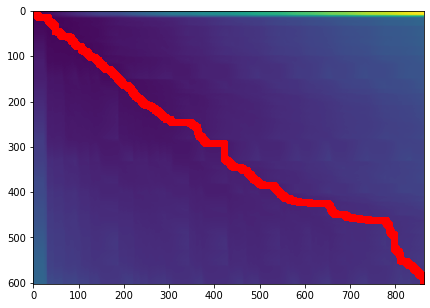

In [ ]:
plt.figure(figsize=(7, 7))
choices, arr_dp = _dtw(X1, X2)
path = get_path(choices)
plt.imshow(arr_dp)
plt.plot(path[:, 1], path[:, 0], '-rs')

In [ ]:
assert_allclose(path, path_fast)

They are the same, but tbh the technique I used for getting the sub region is not very good... Something like imdilate would be better.

In [ ]:
xres = stretch_audio(x1, x2, sr, path_fast, hop_length)
save_audio('data/gettysburg1_2_fast.wav', xres, sr)

Stretching...
x1.shape =  (308700,)
x2.shape =  (441600,)
x1_stretch.shape =  (443424,)


# Build

In [ ]:
build_notebook()

<IPython.core.display.Javascript object>

Converted hw3.ipynb.
